In [29]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.transforms.functional as trnF
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn.functional as F
import math

from torchvision import models
from tqdm import tqdm

from matplotlib import pyplot as plt
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


In [30]:
arch = 'vgg16'
model = models.__dict__[arch](pretrained=True)
model.cuda().eval()
total_params = sum(p.numel() for p in model.parameters())
print("Arch:", arch, " Parameters:", total_params)

Arch: vgg16  Parameters: 138357544


In [31]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

unnorm_fn = lambda x: (x * torch.tensor([0.229, 0.224, 0.225])) + torch.tensor([0.485, 0.456, 0.406])

def show_image(img, plt, unnormalize=True):
    print(img.shape)
    if len(img.shape) == 2:
        npimg = np.asarray(img)
        print(npimg.shape)
        # plt.figure(figsize = (10,10))
        plt.imshow(npimg, interpolation='nearest')
        return
    
    img = img.permute((1,2,0))
    if unnormalize:
        img = unnorm_fn(img).clamp(0, 1)
    npimg = np.asarray(img)
    print(npimg.shape)
    # plt.figure(figsize = (10,10))
    plt.imshow(npimg, interpolation='nearest')


In [32]:
import random
import torch 

import logging
import functools
import inspect

import numpy as np

import torchvision


"""
All transforms here are backprop-able. They expect PyTorch tensors and return PyTorch tensors
    Input:  C x H x W
    Output: C X H X W
"""

def Grayscale(tensor):
    num_channels = tensor.shape[0]
    mean = torch.mean(tensor, dim=0, keepdim=True)
    tensor = torch.cat([mean for _ in range(num_channels)], dim=0)
    return tensor

def HorizontalFlip(tensor):
    tensor = torch.flip(tensor, dims=[2])
    return tensor

def VerticalFlip(tensor):
    tensor = torch.flip(tensor, dims=[1])
    return tensor

def TranslateX(tensor, shift_x):
        IMG_SIZE = tensor.shape[1]

        out = torch.ones_like(tensor)

        # Handle x-shift
        if shift_x >= 0:
            out[:,:, shift_x:] = tensor[:,:, :IMG_SIZE - shift_x]
            out[:,:, :shift_x] = 0
        else:
            out[:,:, :shift_x] = tensor[:, :, -shift_x:]
            out[:,:, shift_x:] = 0
        
        return out

def TranslateY(tensor, shift_y):
        IMG_SIZE = tensor.shape[1]
        
        out = torch.ones_like(tensor)

        # Handle y-shift
        if shift_y >= 0:
            out[:, shift_y:] = tensor[:, :IMG_SIZE - shift_y]
            out[:, :shift_y] = 0
        else:
            out[:, :shift_y] = tensor[:, -shift_y:]
            out[:, shift_y:] = 0
        return out

def ColorShift(tensor, shift_c1, shift_c2, shift_c3):
    tensor[0, :, :] *= shift_c1
    tensor[1, :, :] *= shift_c2
    tensor[2, :, :] *= shift_c3
    return tensor

def Rotate(tensor, k):
    return torch.rot90(tensor, k=k, dims=[1, 2])

def PermuteColorChannels(tensor, color_channels):
    return tensor[color_channels, :, :]

def MirrorPadOffset(tensor, dx, dy, max_offset):
    """
    From E-LPIPS
    """
    orig_size = tensor.shape[2]
    pad_bottom = max_offset - dy
    pad_left   = max_offset - dx
    pad_top    = dy
    pad_right  = dx

    rpad = torch.nn.ReflectionPad2d((pad_left, pad_right, pad_top, pad_bottom))

    tensor = tensor.unsqueeze(0)
    padded = rpad(tensor).squeeze(0)  # (C, H + max_offset, W + max_offset)
    return padded

def DownscaleBox(tensor, scale):
    if scale == 1:
        return tensor
    
    C, H, W = tensor.shape[0], tensor.shape[1], tensor.shape[2]

    res = torch.zeros((C, H, W))

    assert H % scale == 0
    assert W % scale == 0
    assert H == W

    new_height = H // scale
    new_width = W // scale

    tensor = torch.reshape(tensor, (C, new_height, scale, new_width, scale))
    tensor = torch.mean(tensor, dim=[2, 4])

    top_index = random.randint(0, H - new_height - 1)
    left_index = random.randint(0, W - new_width - 1)
    res[:, top_index:(top_index + new_height), left_index:(left_index + new_width)] = tensor
    return res

def SwapXY(tensor):
    return tensor.permute(0, 2, 1)

def sample_transformation(max_offset=15):
    dx, dy = random.randint(0, max_offset), random.randint(0, max_offset)
    shift_r, shift_g, shift_b = random.uniform(0.2, 1.0), random.uniform(0.2, 1.0), random.uniform(0.2, 1.0)
    
    flip_x, flip_y, swap_xy = random.randint(0, 1), random.randint(0, 1), random.randint(0, 1)
    
    
    rotate_k = random.randint(0, 3)

    permute_color_channels_order = [0, 1, 2]
    random.shuffle(permute_color_channels_order)

    choices = np.array([1, 2])
    probs = (1 / (choices ** 2)) / (np.sum(1 / (choices ** 2)))
    scale = np.random.choice(
        choices,
        p=probs
    )
    # scale_dx = random.randint(0, scale - 1)
    # scale_dy = random.randint(0, scale - 1)

    def transform(tensor):
        tensor = TranslateX(tensor, shift_x=dx)
        tensor = TranslateY(tensor, shift_y=dy)
        # tensor = MirrorPadOffset(tensor, dx, dy, max_offset)
        # tensor = DownscaleBox(tensor, scale)
        # if flip_x == 1:
        #     tensor = HorizontalFlip(tensor)
        # if flip_y == 1:
        #     tensor = VerticalFlip(tensor)
        # if swap_xy == 1:
        #     tensor = SwapXY(tensor)
        tensor = ColorShift(tensor, shift_c1=shift_r, shift_c2=shift_g, shift_c3=shift_b)
        # tensor = Rotate(tensor, k=rotate_k)
        # tensor = PermuteColorChannels(tensor, color_channels=permute_color_channels_order)
        return tensor

    return scale, transform

class BPTransform(object):

    def __init__(self, max_offset=None):
        self.max_offset = max_offset
        pass

    def __call__(self, sample):
        if self.max_offset:
            scale, transform = sample_transformation(max_offset = self.max_offset)
        else:
            scale, transform = sample_transformation()
        return transform(sample)


In [37]:
from PIL import Image
def get_white_noise_image(w,h):
    _min, _max = 0, 255
    pil_map = Image.fromarray(np.random.randint(_min,_max,(w,h,3),dtype=np.dtype('uint8')))
    return pil_map

def transform_batch(_input):
    new_batch = torch.zeros((num_tf, 3, 224, 224))
    for i in range(num_tf):
        tf = sample_transformation()[1]
        tfed = tf(_input)
        new_batch[i] = tfed
    
    return new_batch

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

target_class = 182
X_orig = get_white_noise_image(224, 224)
X_orig = transform(X_orig)
X_orig = X_orig.float().cuda()

num_iter = 1000
num_tf = 100

X = X_orig.clone() 
X.requires_grad = True
y = torch.tensor([target_class] * num_tf).long().cuda()

optimizer = torch.optim.AdamW([X], lr=0.05, weight_decay=0.005)
for i in range(num_iter):
    X_tf = transform_batch(X).cuda()
    logits = model(X_tf)
    loss = F.cross_entropy(logits, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 1 == 0:
        print(f"Iter {i}", F.softmax(logits)[0][target_class].item())
    
print(f"Iter {i}", F.softmax(logits)[0][target_class].item())


/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Iter 0 6.98799776728265e-05
Iter 1 0.00013787741772830486
Iter 2 0.0013801136519759893
Iter 3 0.002143708523362875
Iter 4 0.00969627033919096
Iter 5 0.044308118522167206
Iter 6 0.08706553280353546
Iter 7 0.08754820376634598
Iter 8 0.1291908174753189
Iter 9 0.5727949142456055
Iter 10 0.34625115990638733
Iter 11 0.7885635495185852
Iter 12 0.8627474308013916
Iter 13 0.9099407196044922
Iter 14 0.9201101064682007
Iter 15 0.8695969581604004
Iter 16 0.9481450319290161
Iter 17 0.9662219882011414
Iter 18 0.9624108672142029
Iter 19 0.9756990671157837
Iter 20 0.9588868618011475
Iter 21 0.9926400184631348
Iter 22 0.9986593723297119
Iter 23 0.9884472489356995
Iter 24 0.9985639452934265
Iter 25 0.9979798197746277
Iter 26 0.969713568687439
Iter 27 0.9967897534370422
Iter 28 0.9956965446472168
Iter 29 0.9983770847320557
Iter 30 0.996831476688385
Iter 31 0.9959906935691833
Iter 32 0.9973723888397217
Iter 33 0.9976100921630859
Iter 34 0.9991890788078308
Iter 35 0.9991858601570129
Iter 36 0.9997603297233

Iter 297 0.9999861717224121
Iter 298 0.9998805522918701
Iter 299 0.9999327659606934
Iter 300 0.9999655485153198
Iter 301 0.9999749660491943
Iter 302 0.9999556541442871
Iter 303 0.9990972280502319
Iter 304 0.9997419714927673
Iter 305 0.9999041557312012
Iter 306 0.9999964237213135
Iter 307 0.9999902248382568
Iter 308 0.9999865293502808
Iter 309 0.9999469518661499
Iter 310 0.9999289512634277
Iter 311 0.9999736547470093
Iter 312 0.999962568283081
Iter 313 0.9999756813049316
Iter 314 0.999990701675415
Iter 315 0.9999599456787109
Iter 316 0.9998020529747009
Iter 317 0.9999839067459106
Iter 318 0.9997896552085876
Iter 319 0.99958735704422
Iter 320 0.9999784231185913
Iter 321 0.998855710029602
Iter 322 0.9999911785125732
Iter 323 0.9999823570251465
Iter 324 0.9999871253967285
Iter 325 0.9995861649513245
Iter 326 0.9999871253967285
Iter 327 0.9999725818634033
Iter 328 0.9998868703842163
Iter 329 0.999868631362915
Iter 330 0.9999573230743408
Iter 331 0.9988012313842773
Iter 332 0.999980330467224

Iter 591 0.9999853372573853
Iter 592 0.999987006187439
Iter 593 0.9999966621398926
Iter 594 0.9999961853027344
Iter 595 0.9999896287918091
Iter 596 0.9999926090240479
Iter 597 0.9999884366989136
Iter 598 0.9999879598617554
Iter 599 0.9999792575836182
Iter 600 0.9999988079071045
Iter 601 0.9999905824661255
Iter 602 0.9999971389770508
Iter 603 0.9999550580978394
Iter 604 0.9999401569366455
Iter 605 0.9999853372573853
Iter 606 0.9998692274093628
Iter 607 0.9999836683273315
Iter 608 0.9999960660934448
Iter 609 0.99998939037323
Iter 610 0.999901294708252
Iter 611 0.9999910593032837
Iter 612 0.9999697208404541
Iter 613 0.9998329877853394
Iter 614 0.9999980926513672
Iter 615 0.9999827146530151
Iter 616 0.9998935461044312
Iter 617 0.9999922513961792
Iter 618 0.998600423336029
Iter 619 0.9999961853027344
Iter 620 0.9999856948852539
Iter 621 0.9999960660934448
Iter 622 0.999998927116394
Iter 623 0.999996542930603
Iter 624 0.9999539852142334
Iter 625 0.9999964237213135
Iter 626 0.999931812286377


Iter 885 0.9999898672103882
Iter 886 0.999994158744812
Iter 887 0.9999901056289673
Iter 888 0.9999909400939941
Iter 889 0.9999935626983643
Iter 890 0.9999973773956299
Iter 891 0.9999979734420776
Iter 892 0.9999988079071045
Iter 893 0.9999854564666748
Iter 894 0.9999082088470459
Iter 895 0.9999985694885254
Iter 896 0.9999995231628418
Iter 897 0.9999352693557739
Iter 898 0.9999946355819702
Iter 899 0.9999208450317383
Iter 900 0.9999969005584717
Iter 901 0.99998939037323
Iter 902 0.9999966621398926
Iter 903 0.9999977350234985
Iter 904 0.9999938011169434
Iter 905 0.9999903440475464
Iter 906 0.9999991655349731
Iter 907 0.999866247177124
Iter 908 0.9999769926071167
Iter 909 0.9998364448547363
Iter 910 0.9999822378158569
Iter 911 0.9999927282333374
Iter 912 0.9999985694885254
Iter 913 0.9999936819076538
Iter 914 0.9999951124191284
Iter 915 0.999988317489624
Iter 916 0.9999985694885254
Iter 917 0.9999971389770508
Iter 918 0.9999977350234985
Iter 919 0.9999982118606567
Iter 920 0.99999785423278

/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(39380.8672, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.1708, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2165, device='cuda:0')
torch.Size([3, 224, 224])
(224, 224, 3)
torch.Size([3, 224, 224])
(224, 224, 3)
torch.Size([3, 224, 224])
(224, 224, 3)


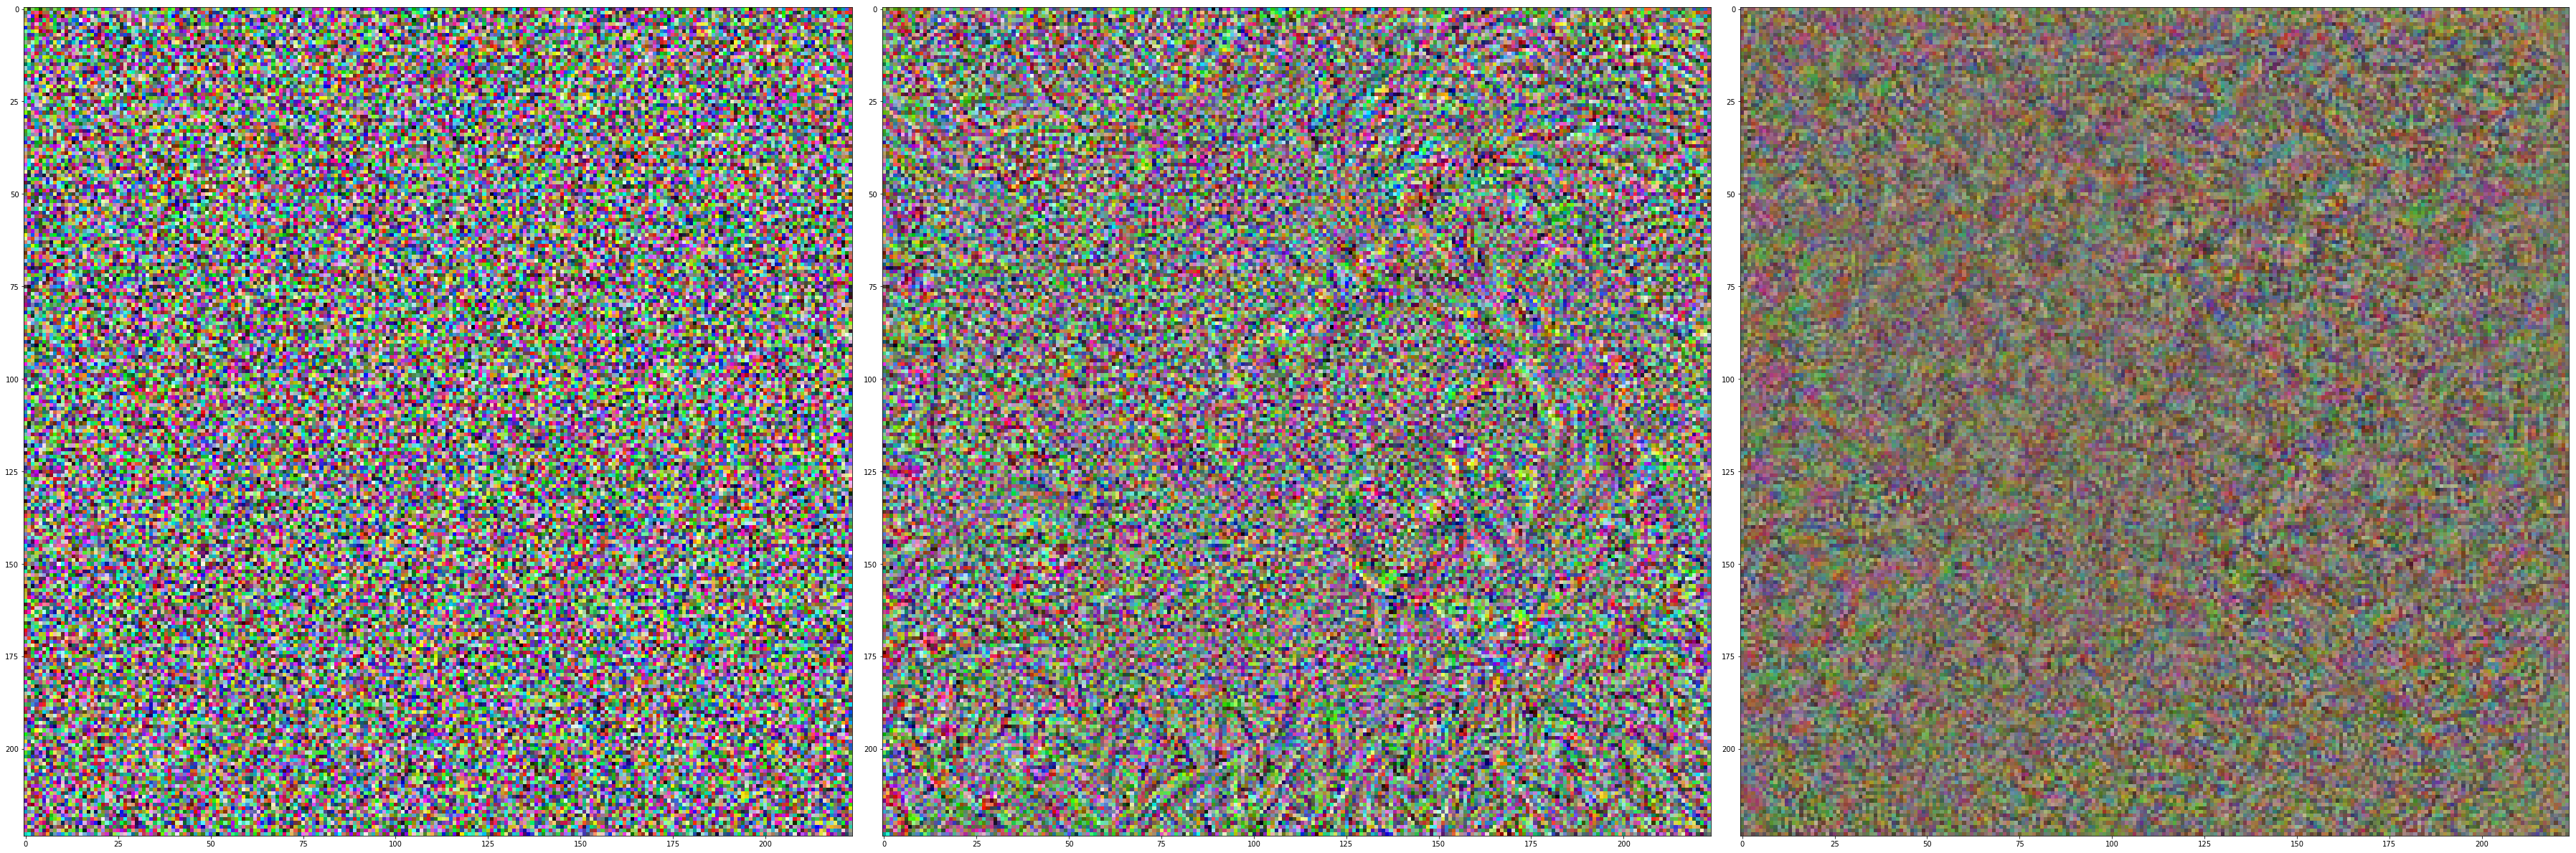

In [38]:

fig, ax = plt.subplots(1,3)
fig.set_size_inches(50, 70)
fig.tight_layout()

print(torch.sum((X - X_orig)**2))
print(X.mean())
print(X_orig.mean())

show_image(X_orig.cpu().detach(), ax[0])
show_image(X.cpu().detach(), ax[1])
show_image((X - X_orig).cpu().detach() * 1, ax[2])
